In [7]:
import torch

from ipp_toolkit.config import TORCH_DEVICE
from ipp_toolkit.data.domain_data import (
    SafeForestGMapGreennessRegressionData,
    YellowcatDroneClassificationData,
    AIIRAGreennessRegresssionData,
)
from ipp_toolkit.experiments.comparing_ipp_approaches import (
    compare_across_datasets_and_models,
    compare_planners,
)
from ipp_toolkit.planners.diversity_planner import BatchDiversityPlanner
from ipp_toolkit.planners.masked_planner import (
    LawnmowerMaskedPlanner,
    RandomSamplingMaskedPlanner,
    RandomWalkMaskedPlanner,
)
from ipp_toolkit.predictors.masked_image_predictor import (
    UncertainMaskedLabeledImagePredictor,
)
from ipp_toolkit.predictors.pytorch_predictor import MLPNetwork, PytorchPredictor
from ipp_toolkit.predictors.uncertain_predictors import (
    EnsamblePredictor,
    GaussianProcessRegression,
)


In [8]:
N_CANDIDATE_LOCATIONS_DIVERSITY = 200
RANDOM_WALK_STEP = 50
VISIT_N_LOCATIONS = 3
VIS_PLAN = False
N_TRIALS = 7
N_FLIGHTS = 10

N_LAWNMOWER_SAMPLES = N_FLIGHTS * VISIT_N_LOCATIONS

# Create your different planners
planner_instantiation_funcs = [
#    lambda data: BatchDiversityPlanner(
#        data, n_candidate_locations=N_CANDIDATE_LOCATIONS_DIVERSITY
#    ),
    lambda data: RandomSamplingMaskedPlanner(data),
    lambda data: RandomWalkMaskedPlanner(data),
    lambda data: LawnmowerMaskedPlanner(data, N_LAWNMOWER_SAMPLES),
]
# Add planner-specific keyword arguments
planner_kwargs = [
#    {"vis": VIS_PLAN},
    {"vis": VIS_PLAN},
    {"vis": VIS_PLAN, "step_size": RANDOM_WALK_STEP},
    {"vis": VIS_PLAN},
]


def create_pytorch_predictor(data):
    # Create a prediction model
    input_dim = data.image.shape[-1]
    output_dim = data.n_classes if data.is_classification_dataset() else 1
    model = PytorchPredictor(
        model=MLPNetwork(input_dim=input_dim, output_dim=output_dim),
        classification_task=data.is_classification_dataset(),
        criterion=torch.nn.CrossEntropyLoss()
        if data.is_classification_dataset()
        else torch.nn.MSELoss(),
        device=TORCH_DEVICE,
    )
    ensamble_model = EnsamblePredictor(
        model, classification_task=data.is_classification_dataset()
    )
    predictor = UncertainMaskedLabeledImagePredictor(
        data,
        uncertain_prediction_model=ensamble_model,
        classification_task=data.is_classification_dataset(),
    )
    return predictor


data_managers = [
    YellowcatDroneClassificationData(),
    AIIRAGreennessRegresssionData(),
    SafeForestGMapGreennessRegressionData(),
]
predictor_instantiation_funcs = [
    lambda data: UncertainMaskedLabeledImagePredictor(
        data,
        GaussianProcessRegression(device=TORCH_DEVICE),
        classification_task=data.is_classification_dataset(),
    ),
    create_pytorch_predictor,
]


Everything is up to date.


Running predictor: <class 'ipp_toolkit.predictors.uncertain_predictors.GaussianProcessRegression'>, dataset: aiira
Running planner random_sampling_masked_planner
Running planner random_masked_walk_planner
Running planner lawnmower_planner
Saving to None


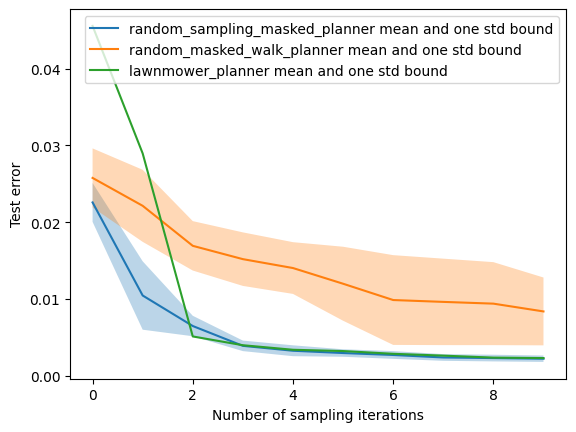

Running predictor: <class 'ipp_toolkit.predictors.uncertain_predictors.EnsamblePredictor'>, dataset: aiira
Running planner random_sampling_masked_planner
Running planner random_masked_walk_planner
Running planner lawnmower_planner
Saving to None


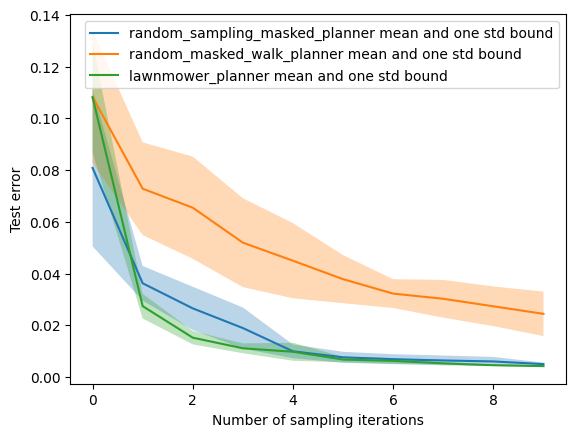

Running predictor: <class 'ipp_toolkit.predictors.uncertain_predictors.GaussianProcessRegression'>, dataset: safeforest_gmaps
Running planner random_sampling_masked_planner
Running planner random_masked_walk_planner
Running planner lawnmower_planner
Saving to None


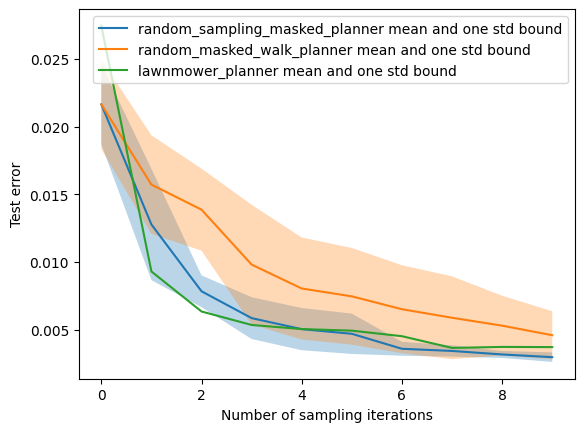

Running predictor: <class 'ipp_toolkit.predictors.uncertain_predictors.EnsamblePredictor'>, dataset: safeforest_gmaps
Running planner random_sampling_masked_planner
Running planner random_masked_walk_planner


In [9]:
compare_across_datasets_and_models(
    data_managers=data_managers,
    predictor_instantiation_funcs=predictor_instantiation_funcs,
    planner_instantiation_funcs=planner_instantiation_funcs,
    each_planners_kwargs=planner_kwargs,
    visit_n_locations=VISIT_N_LOCATIONS,
    n_trials=N_TRIALS,
    n_flights=N_FLIGHTS,
)
